In [22]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os
from pyspark.sql.functions import col, lit, to_date, split, when, coalesce
from pyspark.sql.types import MapType, StringType

In [23]:
spark = SparkSession.builder \
                    .appName('tennis') \
                    .getOrCreate()

In [29]:
singles=spark.read.option("header","true").option("inferSchema","true") \
.csv('singles')

singles.show(2)

+----------+------------+-------+---------+-------------+------------+---------+---------+-----------+------------+--------------+-----------+---------+----------+----------+--------+----------+-----------+-------------+----------+--------+---------+---------+-----------+-------+-----+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+-----------------+
|tourney_id|tourney_name|surface|draw_size|tourney_level|tourney_date|match_num|winner_id|winner_seed|winner_entry|   winner_name|winner_hand|winner_ht|winner_ioc|winner_age|loser_id|loser_seed|loser_entry|   loser_name|loser_hand|loser_ht|loser_ioc|loser_age|      score|best_of|round|minutes|w_ace|w_df|w_svpt|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|w_bpSaved|w_bpFaced|l_ace|l_df|l_svpt|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_bpSaved|l_bpFaced|winner_rank|winner_rank_points|loser_rank|loser_rank_points|
+-

In [30]:
from pyspark.sql.functions import col, count, round

null_counts = singles.select([round(((count(when(col(c).isNull(), c)) / singles.count()) * 100), 1).alias(c) for c in singles.columns])
null_counts.show()

+----------+------------+-------+---------+-------------+------------+---------+---------+-----------+------------+-----------+-----------+---------+----------+----------+--------+----------+-----------+----------+----------+--------+---------+---------+-----+-------+-----+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+-----------------+
|tourney_id|tourney_name|surface|draw_size|tourney_level|tourney_date|match_num|winner_id|winner_seed|winner_entry|winner_name|winner_hand|winner_ht|winner_ioc|winner_age|loser_id|loser_seed|loser_entry|loser_name|loser_hand|loser_ht|loser_ioc|loser_age|score|best_of|round|minutes|w_ace|w_df|w_svpt|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|w_bpSaved|w_bpFaced|l_ace|l_df|l_svpt|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_bpSaved|l_bpFaced|winner_rank|winner_rank_points|loser_rank|loser_rank_points|
+----------+------------+-

In [38]:
selected_columns = ['surface',
                    'tourney_level',
                    'match_num',
                    'winner_id',
                    'winner_hand', 
                    'winner_ht', 
                    'winner_ioc',
                    'winner_age', 
                    'loser_id',
                    'loser_hand',
                    'loser_ioc',
                    'loser_age',
                    'best_of',
                    'round'
                   ]

clean_df = singles.select(selected_columns)
clean_df = clean_df.dropna()
clean_df.show()

+-------+-------------+---------+---------+-----------+---------+----------+----------+--------+----------+---------+---------+-------+-----+
|surface|tourney_level|match_num|winner_id|winner_hand|winner_ht|winner_ioc|winner_age|loser_id|loser_hand|loser_ioc|loser_age|best_of|round|
+-------+-------------+---------+---------+-----------+---------+----------+----------+--------+----------+---------+---------+-------+-----+
|   Hard|            A|        1|   101404|          L|      180|       AUT|      26.2|  101214|         R|      USA|     28.0|      3|  R32|
|   Hard|            A|        2|   101917|          R|      188|       RSA|      22.6|  101190|         R|      AUS|     28.2|      3|  R32|
|   Hard|            A|        3|   102158|          R|      185|       AUS|      21.0|  210013|         R|      CZE|     21.4|      3|  R32|
|   Hard|            A|        4|   101601|          R|      185|       NZL|      24.6|  101647|         R|      ZIM|     24.2|      3|  R32|
|   Ha

For the correlation matrix, only numerical values can be analysed. We will give a different id per different value in the attributes where this processing makes sense.

In [39]:
from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCol='winner_ioc', outputCol='winner_country_id')
indexed_df = string_indexer.fit(clean_df).transform(clean_df)

string_indexer = StringIndexer(inputCol='loser_ioc', outputCol='loser_country_id')
indexed_df = string_indexer.fit(indexed_df).transform(indexed_df)

string_indexer = StringIndexer(inputCol='winner_hand', outputCol='winner_hand_id')
indexed_df = string_indexer.fit(indexed_df).transform(indexed_df)

string_indexer = StringIndexer(inputCol='loser_hand', outputCol='loser_hand_id')
indexed_df = string_indexer.fit(indexed_df).transform(indexed_df)

string_indexer = StringIndexer(inputCol='round', outputCol='round_id')
indexed_df = string_indexer.fit(indexed_df).transform(indexed_df)

string_indexer = StringIndexer(inputCol='tourney_level', outputCol='tourney_level_id')
indexed_df = string_indexer.fit(indexed_df).transform(indexed_df)

string_indexer = StringIndexer(inputCol='surface', outputCol='surface_id')
indexed_df = string_indexer.fit(indexed_df).transform(indexed_df)


columns_to_drop = ['winner_ioc', 'loser_ioc', 'winner_hand', 'loser_hand', 'round', 'tourney_level', 'surface']
indexed_df = indexed_df.drop(*columns_to_drop)

indexed_df.show()

+---------+---------+---------+----------+--------+---------+-------+-----------------+----------------+--------------+-------------+--------+----------------+----------+
|match_num|winner_id|winner_ht|winner_age|loser_id|loser_age|best_of|winner_country_id|loser_country_id|winner_hand_id|loser_hand_id|round_id|tourney_level_id|surface_id|
+---------+---------+---------+----------+--------+---------+-------+-----------------+----------------+--------------+-------------+--------+----------------+----------+
|        1|   101404|      180|      26.2|  101214|     28.0|      3|             16.0|             0.0|           1.0|          0.0|     0.0|             0.0|       0.0|
|        2|   101917|      188|      22.6|  101190|     28.2|      3|             12.0|             2.0|           0.0|          0.0|     0.0|             0.0|       0.0|
|        3|   102158|      185|      21.0|  210013|     21.4|      3|              2.0|             8.0|           0.0|          0.0|     0.0|   

In [62]:
from pyspark.sql.functions import corr

correlation_matrix = []

for col1 in indexed_df.columns:
    col1_correlation = []
    for col2 in indexed_df.columns:
        correlation = indexed_df.corr(col1, col2)
        col1_correlation.append(correlation)
    correlation_matrix.append(col1_correlation)

print("Correlation coefficient:", correlation_matrix)

# correlation_matrix = indexed_df.select([corr(col1, col2).alias(f'corr_{col1}_{col2}') 
#                                 for col1 in indexed_df.columns 
#                                 for col2 in indexed_df.columns])

Correlation coefficient: [[1.0, 0.24932789483158216, 0.07058373304100214, 0.13401368145757725, 0.24550561536332752, 0.1254499861057677, 0.06270364237942917, -0.024385694913660744, -0.03240490626393744, 0.00782515093402612, 0.0011043554791919205, 0.022673061007211847, -0.05088956555613406, -0.044339924614006], [0.24932789483158213, 1.0, 0.09306992391408181, -0.13435688526477185, 0.3533435948733846, 0.06497982837696445, -0.009291062653909762, 0.060578362542200795, 0.05869158578005554, -0.02465907806995758, 0.002589013846328346, 0.02101644934675024, 0.060226202267703643, -0.10322786373311642], [0.07058373304100214, 0.09306992391408181, 1.0, -0.014469717618932973, 0.08712621447150702, 0.036009354106870506, 0.008925021366723015, 0.015602216543207292, 0.013398780974550918, -0.0625229148288743, -0.005033075700886532, 0.006698886659810911, 0.05172717124979176, -0.04305452331708481], [0.13401368145757725, -0.13435688526477188, -0.014469717618932967, 1.0, 0.05726376452040945, 0.09374803124804387

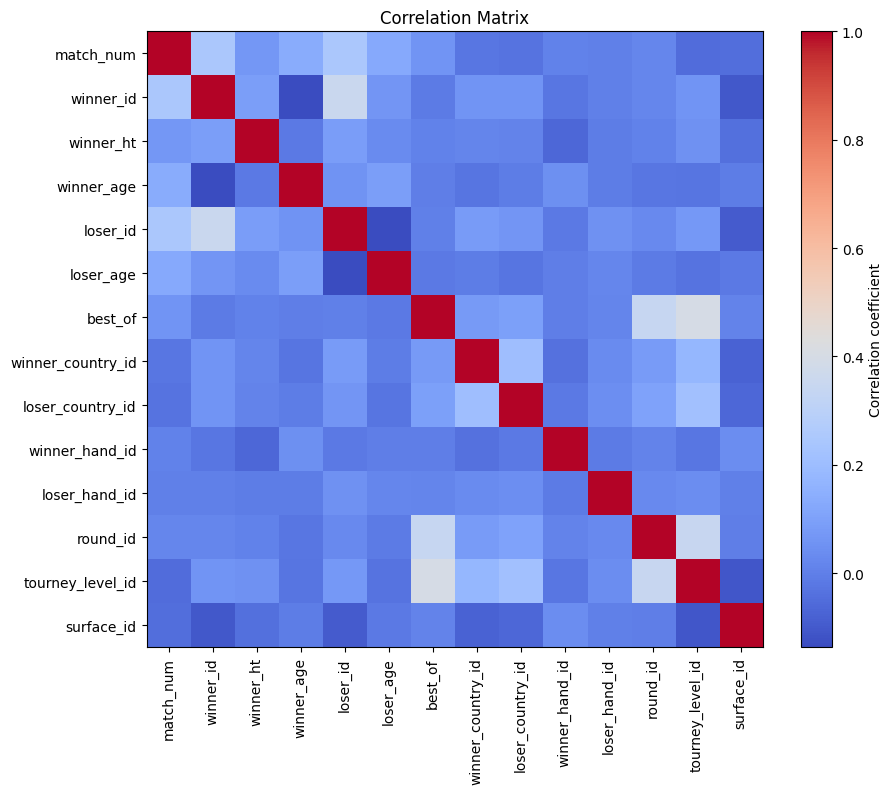

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation coefficient')
plt.title('Correlation Matrix')
plt.xticks(range(len(correlation_matrix)), indexed_df.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), indexed_df.columns)
plt.show()